In [10]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from community import community
matplotlib.rc("figure", figsize=(10,5))

In [2]:
def plot_growth_profile(community):
    ''' Plot growth profiles of the community
    
    Parameters:
    
    community: community object
    
    Returns:
    
    fig: figure object
    
    '''
    
    
    #set colors
    yellow = np.array([246,219,147])/255
    blue = np.array([42,86,152])/255
    
    #calculate growth profiles
    x_vec = np.linspace(0,30,1000)
    community.calc_growth_profiles(x_vec)
    
    #normalize to WT growth rate
    muWT = community.mu0 * 3600
    
    #plot growth profiles
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    ax.plot(community.x_T, community.mu_profile_T/muWT, color=yellow, label='dT')
    ax.plot(community.x_P, community.mu_profile_P/muWT, color=blue, label='dP')
    ax.set_xlabel('Position (um)')
    ax.set_ylabel('Growth rate relative to WT')
    ax.set_ylim(0,1)
    
    #add reference lines
    plt.axvline(x=0, color='k', linestyle='-')
    plt.axvline(x=community.rangeP, color=blue, linestyle=':')
    plt.axvline(x=-community.rangeT, color=yellow, linestyle=':')

    return fig

In [12]:
#read fit_par dictionary from fit_pars.csv
with open('fit_pars_new.csv', 'r') as f:
    fit_par = {}
    for line in f:
        #split line by comma
        line = line.split(',')
        par = line[1].split('\n')
        #first element is key, second is value
        fit_par[line[0]] = float(par[0])

print('Fit parameters:', fit_par)

Fit parameters: {'lPro': 3.430469286314919e-06, 'lTrp': 3.764935806792471e-07, 'c_up_P': 123.6161616161616, 'cost_putP': 0.175, 'c_prod_T': 22.0, 'c_prod_P': 2.909090909090909, 'c_up_P2': 126.63131313131312, 'cost_putP2': 0.335}


---

## Predict community dynamics

In [16]:
df_all = pd.read_csv('data.csv')
df_all['rel_range'] = df_all['dP_patch']/df_all['dT_patch']

df = df_all.groupby('Condition').mean()
df['rel_growth'] = df['Width']/df.loc['WT','Width']

communityA = community(lPro=fit_par['lPro'], lTrp=fit_par['lTrp'])
communityC = community(lPro=fit_par['lPro'], lTrp=fit_par['lTrp'], c_prod_T=fit_par['c_prod_T'])
communityE = community(lPro=fit_par['lPro'], lTrp=fit_par['lTrp'], c_prod_P=fit_par['c_prod_P'])
communityG = community(lPro=fit_par['lPro'], lTrp=fit_par['lTrp'], c_prod_T=fit_par['c_prod_T'],c_prod_P=fit_par['c_prod_P'])

communityB = community(lPro=fit_par['lPro'], lTrp=fit_par['lTrp'], c_cost_dP=fit_par['cost_putP'], c_up_P=fit_par['c_up_P'])
communityD = community(lPro=fit_par['lPro'], lTrp=fit_par['lTrp'], c_cost_dP=fit_par['cost_putP'], c_up_P=fit_par['c_up_P'], c_prod_T=fit_par['c_prod_T'])
communityF = community(lPro=fit_par['lPro'], lTrp=fit_par['lTrp'], c_cost_dP=fit_par['cost_putP'], c_up_P=fit_par['c_up_P'], c_prod_P=fit_par['c_prod_P'])
communityH = community(lPro=fit_par['lPro'], lTrp=fit_par['lTrp'], c_cost_dP=fit_par['cost_putP'], c_up_P=fit_par['c_up_P'], c_prod_T=fit_par['c_prod_T'],c_prod_P=fit_par['c_prod_P'])

communities = {'A': communityA, 'B': communityB, 'C': communityC, 'D': communityD, 'E': communityE, 'F': communityF, 'G': communityG, 'H': communityH}

for key, val in communities.items():
    df.loc[key, 'predicted_ratio'] = val.eq
    df.loc[key, 'predicted_rel_growth'] = val.rel_growth_wt
    df.loc[key, 'predicted_rel_range'] = val.rangeP/val.rangeT
    df.loc[key, 'predicted_rangeP'] = val.rangeP
    df.loc[key, 'predicted_rangeT'] = val.rangeT

df.drop('WT',axis=0,inplace=True)
df.reset_index(inplace=True)

columns_data={'Condition': 'community', 'Ratio': 'eq freq', 'rel_growth': 'relative growth', 'rel_range': 'relative range', 'dT_patch': 'range dT', 'dP_patch': 'range dP'}
columns_pred={'Condition': 'community', 'predicted_ratio': 'eq freq', 'predicted_rel_growth': 'relative growth', 'predicted_rel_range': 'relative range', 'predicted_rangeT': 'range dT', 'predicted_rangeP': 'range dP'}

df_data = df[[x for x in columns_data.keys()]].rename(columns=columns_data)
df_data['source'] = 'data'

df_pred = df[[x for x in columns_pred.keys()]].rename(columns=columns_pred)
df_pred['source'] = 'prediction'

df_plot = pd.concat([df_data, df_pred]).reset_index(drop=True)

Text(3.9, -0.1, '*')

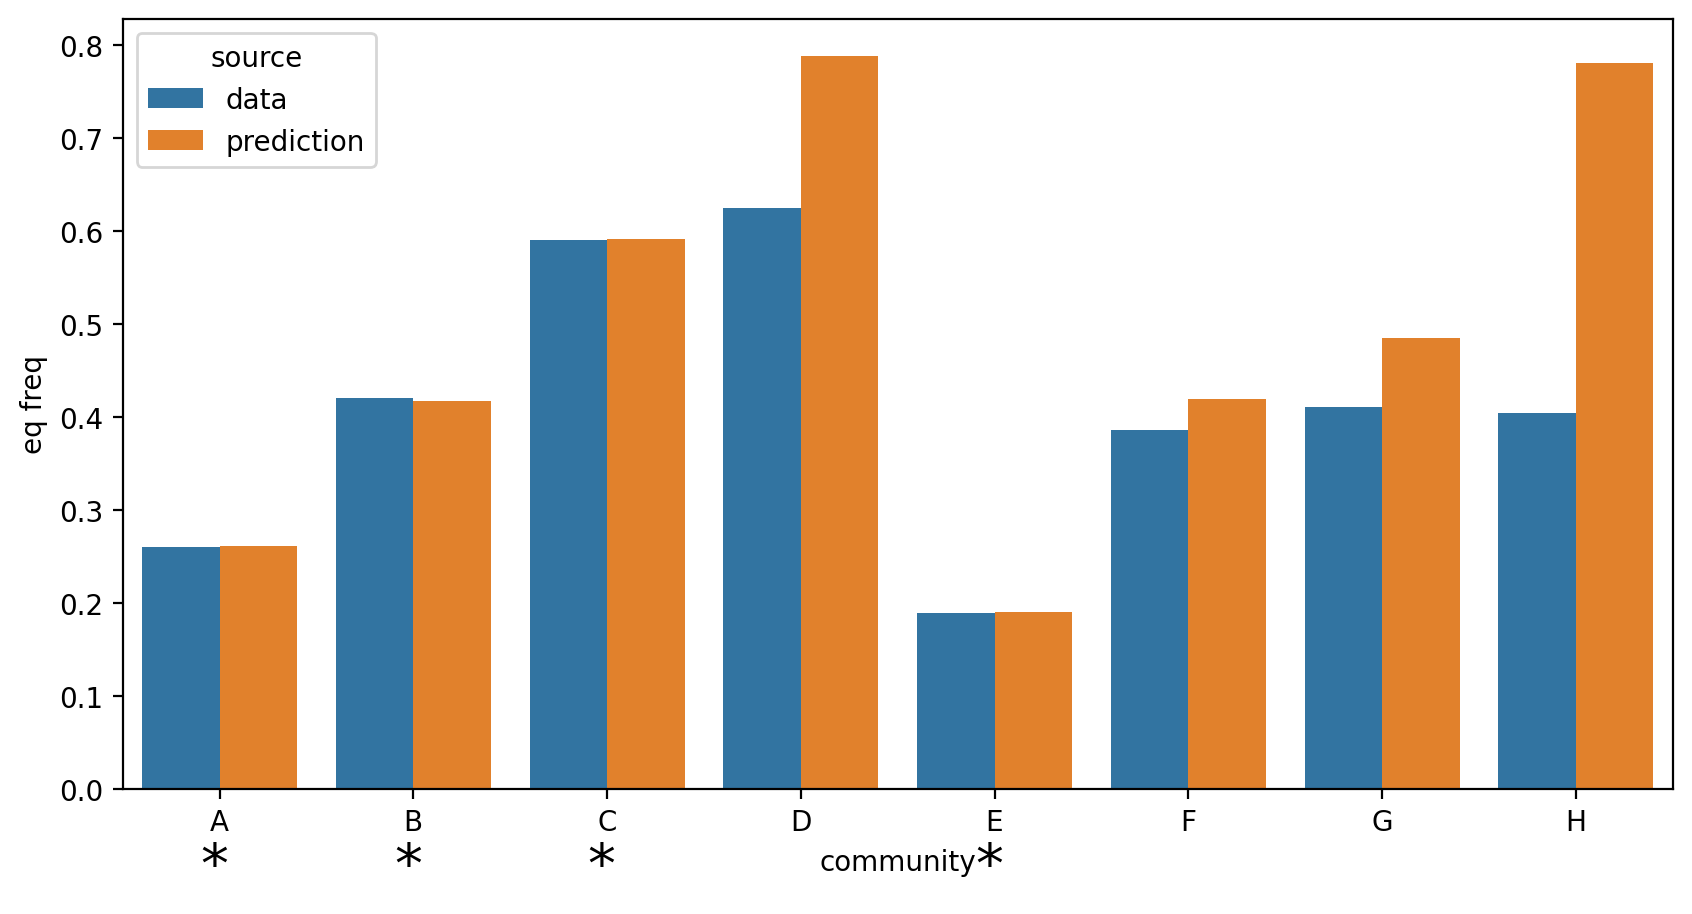

In [22]:
fig1=sns.barplot(df_plot, x="community", y="eq freq", hue="source")
fig1.text(-0.1, -0.1, '*', fontsize=20, color='k',horizontalalignment='left')
fig1.text(1.9, -0.1, '*', fontsize=20, color='k',horizontalalignment='left')
fig1.text(0.9, -0.1, '*', fontsize=20, color='k',horizontalalignment='left')
fig1.text(3.9, -0.1, '*', fontsize=20, color='k',horizontalalignment='left')


Text(3.9, -0.1, '*')

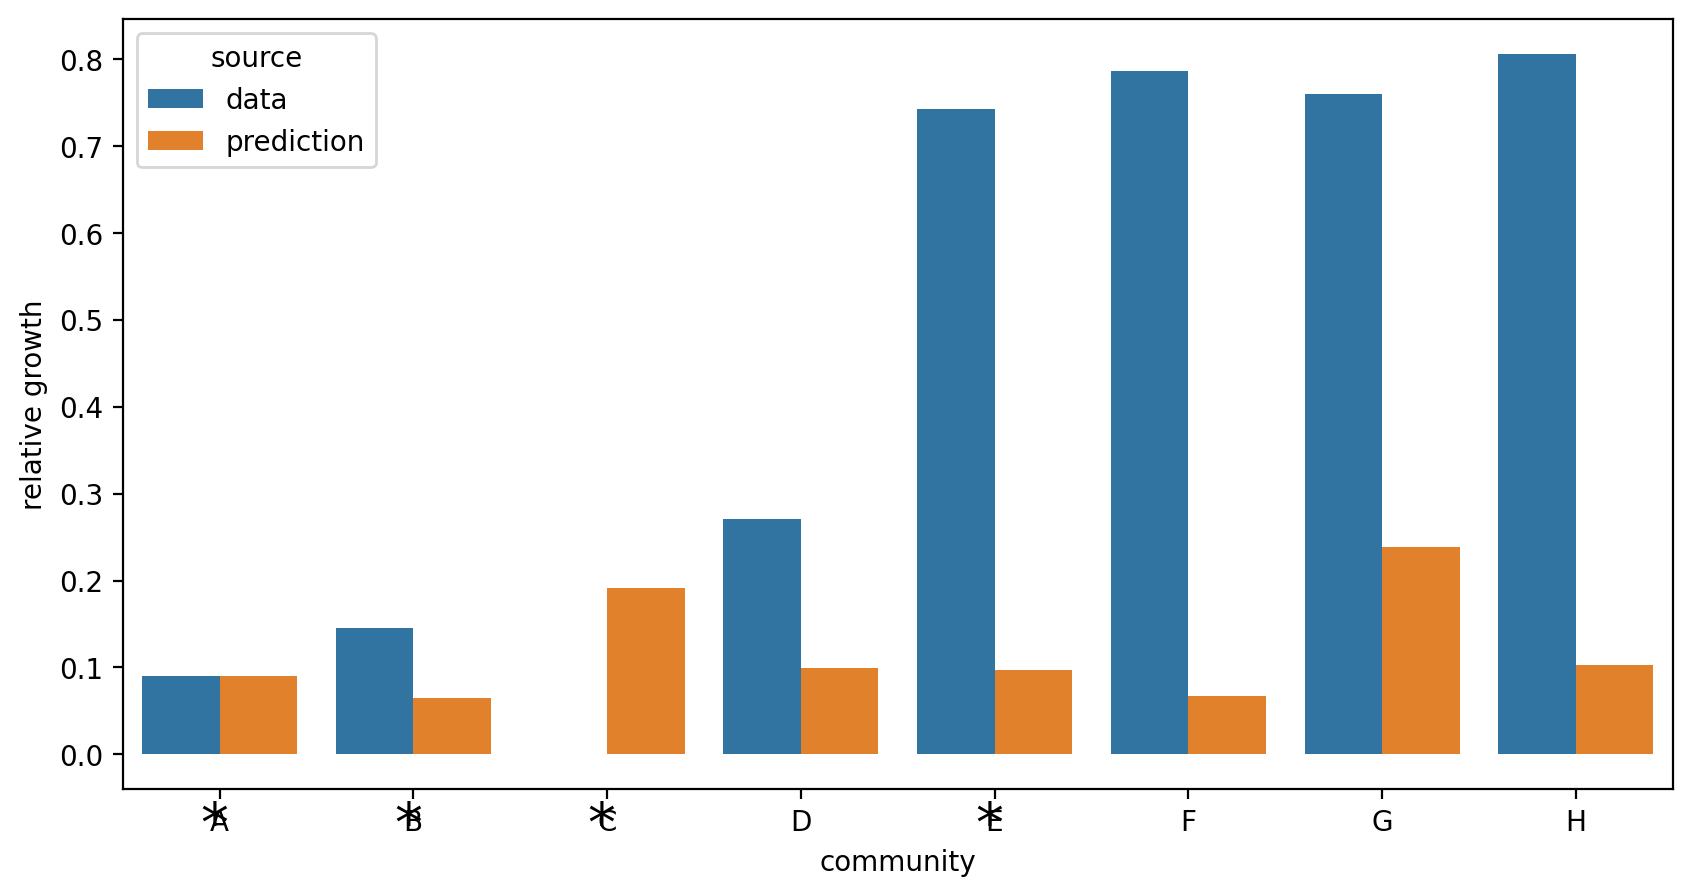

In [24]:
fig2=sns.barplot(df_plot, x="community", y="relative growth", hue="source")
fig2.text(-0.1, -0.1, '*', fontsize=20, color='k',horizontalalignment='left')
fig2.text(1.9, -0.1, '*', fontsize=20, color='k',horizontalalignment='left')
fig2.text(0.9, -0.1, '*', fontsize=20, color='k',horizontalalignment='left')
fig2.text(3.9, -0.1, '*', fontsize=20, color='k',horizontalalignment='left')

Text(0.9, -0.1, '*')

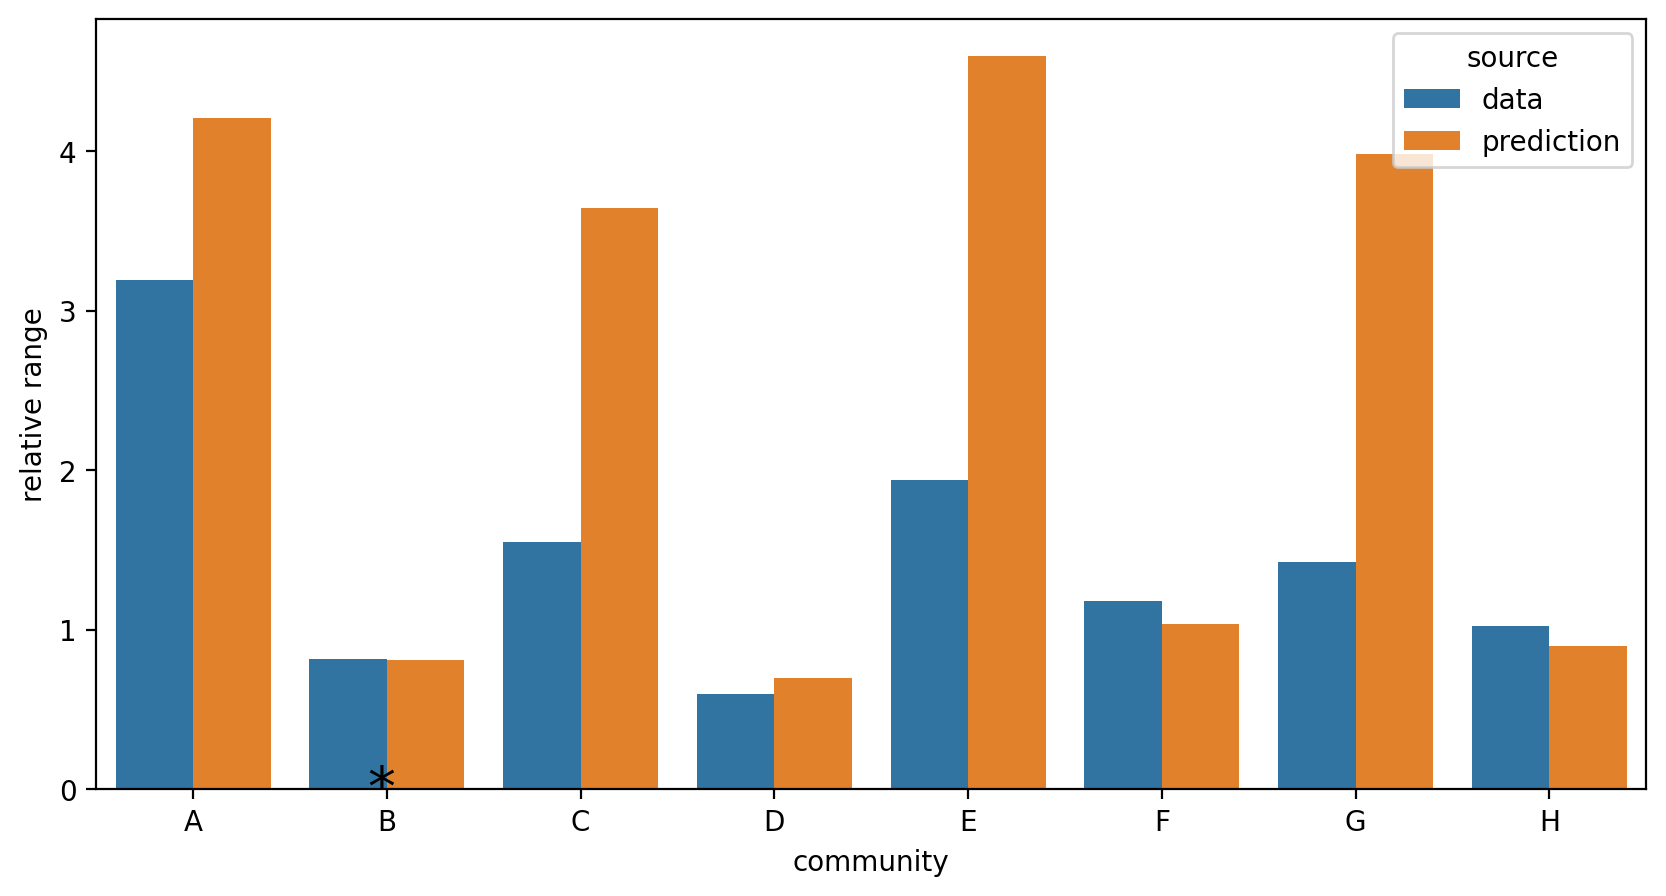

In [27]:
fig3=sns.barplot(df_plot, x="community", y="relative range", hue="source")
fig3.text(0.9, -0.1, '*', fontsize=20, color='k',horizontalalignment='left')

Frequency dT = 0.48
Clustering dT = 0.92, Clustering dP = 0.99
Growth relative to WT = 0.24
Growth defect spatial community = 0.95
mu_max dP = 0.66, mu_max dT = 0.63
range dP = 11.40um, range dT = 2.87um


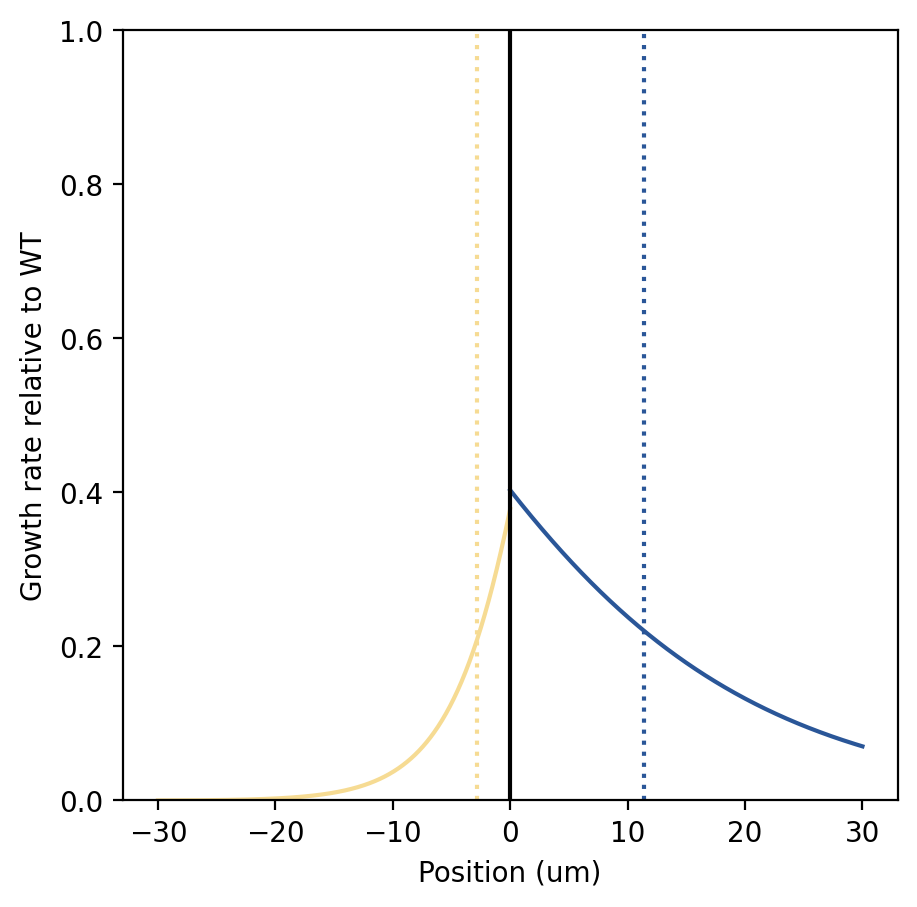

In [20]:
communityG.report_properties()
fig = plot_growth_profile(communityG)

In [21]:
df

,Condition,Rep,Ratio,Width,dT_patch,dP_patch,rel_range,rel_growth,predicted_ratio,predicted_rel_growth,predicted_rel_range,predicted_rangeP,predicted_rangeT
0,A,1.5,0.260160,98.019242,9.982812,31.874861,3.192974,0.090431,0.261595,0.089702,4.210174,10.445403,2.480991
1,B,1.5,0.420748,157.745055,7.487109,6.117064,0.817013,0.145534,0.417323,0.065233,0.808753,2.006510,2.480991
2,C,1.5,0.590506,-0.064086,7.487109,11.631545,1.553543,-0.000059,0.591721,0.191107,3.645337,10.445403,2.865415
3,D,1.5,0.625429,293.174008,8.314437,4.991406,0.600330,0.270479,0.788722,0.099139,0.700251,2.006510,2.865415
4,E,1.5,0.189678,805.362453,119.452271,231.705899,1.939736,0.743018,0.189898,0.096919,4.595044,11.400261,2.480991
5,F,1.5,0.386470,852.126212,125.763148,148.161343,1.178098,0.786162,0.419718,0.067343,1.038666,2.576921,2.480991
6,G,1.5,0.411337,824.371877,114.111317,162.914291,1.427679,0.760556,0.484557,0.238941,3.978573,11.400261,2.865415
7,H,1.5,0.404812,873.116202,132.916806,135.954874,1.022857,0.805527,0.781393,0.103031,0.899319,2.576921,2.865415
